## Feature extraction from infrared sky images for solar energy estimation

In recent years the idea of a transition to renewable energy sources has progressively gained more strength. Within this movement, solar energy is classified as one of the most important, being a clean alternative to traditional electricity generation systems.

To maximize solar energy production, it is important to have information on atmospheric conditions, especially incident solar radiation. Satellite images have been used to study atmospheric features such as cloud cover and solar radiation estimates. In this field, sky cameras have emerged as a promising technology to study sky conditions with greater precision. These cameras offer a view of the sky with high spatial resolution. Combining satellite images and sky cameras has proven effective in predicting the presence of clouds in the short term. [1] This information is key to adapt the operation of solar power plants to meteorological conditions and achieve better integration of the electricity generated into the grid. 

https://www.sciencedirect.com/science/article/abs/pii/S0169809512001342?via%3Dihub

The objective of this work is to extract features from images gathered with an infrared sky cam on panoramic sky images, for intra-hour solar estiamtion. To achieve this several techniques from image analysis and vision image will be implemented into a single pipeline to obtain the relevant data for further use as inputs in solar prediction models. 

### 1. Image preprocessing 

For this specific workflow the images received were formated as .jp2 files, to handle this type of files the `imageio` library was used. The file type loaded is of type `Uint16`.

uint16


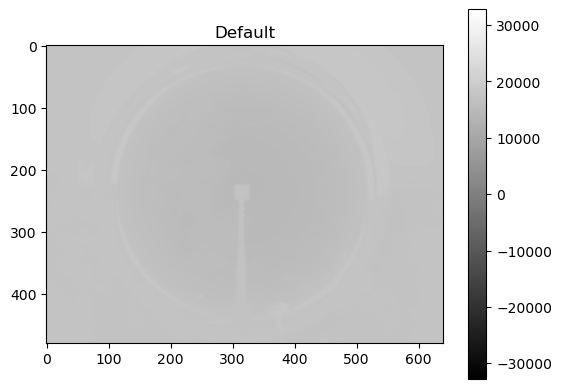

In [2]:
import imageio.v2 as imageio
from PIL import Image, ImageDraw
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import *
from skimage.metrics import *
from skimage.segmentation import *
from skimage.feature import *
from skimage.measure import label, regionprops
from scipy import ndimage as ndi
from scipy.interpolate import *
import pvlib
import copy
import pandas as pd
import blend_modes
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# path to jp2 image
filepath = '20230807/20230807152030.jp2'

# Read the JP2 image
image = imageio.imread(filepath)
print(image.dtype)
# Showing image in default range
plt.imshow(image.astype(int), cmap="gray", vmin=(-2**16)/2-1, vmax=(2**16)/2-1)
plt.title("Default")
plt.colorbar()


Matplotlib by default makes a normalization process when displaying images, by linearly mapping the minimun and maximum values of the image to the `[0.0, 1.0]` interval. To view the image in better detail a color mapping can be applied. In the following example `jet` mapping is applied. Note that the image values in the `img` variable remain unchanged, however the image shown is in the range of `[14537, 18358]`, corresponding to the min and max values of the given image.

14537
18358


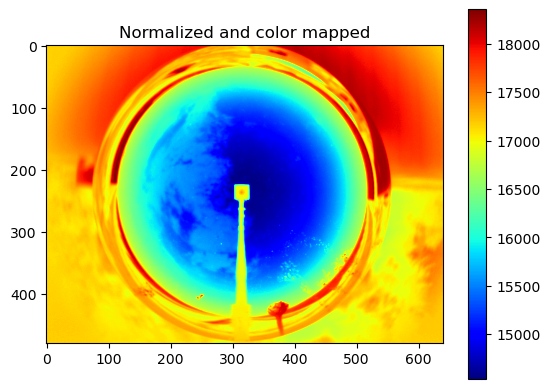

In [3]:
print(np.min(image))
print(np.max(image))
plt.imshow(image.astype(int), cmap="jet")
plt.title("Normalized and color mapped")
plt.colorbar()

`Uint16` is sometimes not the best way to work with image data, for ease of use in the following sections the img variable can be converted to `int32` instead.

In [4]:
# Image gets converted to int32
int_img = image.astype(int)
print(int_img.dtype)

int32


### 2. Solar Position

To get the solar position `pvlib` library was used. This library allowed us to get the solar position for a specific set of coordinates from where the images were taken. This takes into account the time of the year. Since the images are named according to the time when they get taken, the data of the time and date can be extracted from here, for indexing later with `pvlib`.

In [5]:
YY = filepath[-18:-14]
MM = filepath[-14:-12]
DD = filepath[-12:-10]
day = YY+'-'+MM+'-'+DD

st = filepath[-10:-4]
hh = str(int(st[0:2])-5)
if len(hh) == 1:
    hh = '0'+hh
mm = st[2:4]
ss = st[4:6]
timer = hh + ':'+ mm + ':' + ss  

date = day + ' ' + timer + '-05:00'

print(date)

2023-08-07 10:20:30-05:00


<Figure size 640x480 with 0 Axes>

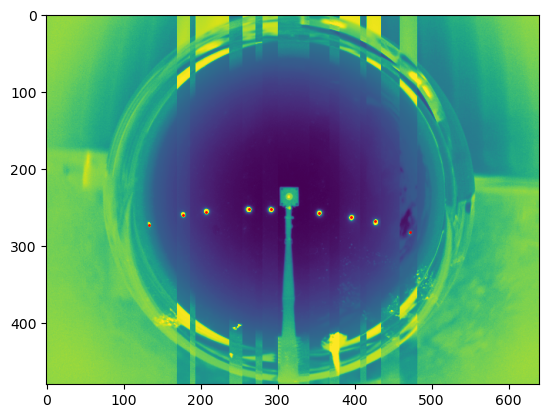

In [6]:
import pvlib 
import pandas as pd
def solar_pos(filepath):
    tz = 'America/Bogota'
    lat, lon = 9.789103, -73.722451 # 9.789103, -73.722451 Esta es las coordenas
    altitude = 50
    #Ubicación Geográfica
    location = pvlib.location.Location(lat, lon, tz, altitude)
    times = pd.date_range('2023-01-01 00:00:00', '2024-12-31', inclusive='left',
                          freq='H', tz=tz)
    solpos = pvlib.solarposition.get_solarposition(times, lat, lon)
    # remove nighttime
    solpos = solpos.loc[solpos['apparent_elevation'] > 0, :]
    # draw hour labels
    for hour in np.unique(solpos.index.hour):
        # choose label position by the smallest radius for each hour
        subset = solpos.loc[solpos.index.hour == hour, :]
        r = subset.apparent_zenith
        pos = solpos.loc[r.idxmin(), :]
        # ax.text(np.radians(pos['azimuth']), pos['apparent_zenith'], str(hour))
    YY = filepath[-18:-14]
    MM = filepath[-14:-12]
    DD = filepath[-12:-10]
    day = YY+'-'+MM+'-'+DD
    # draw individual days
    for date in pd.to_datetime([day]):
        times = pd.date_range(date, date+pd.Timedelta('24h'), freq='30s', tz=tz)
        solpos = pvlib.solarposition.get_solarposition(times, lat, lon)
        solpos = solpos.loc[solpos['apparent_elevation'] > 0, :]
        label = date.strftime('%Y-%m-%d')
        azimuth_radians = np.radians(solpos.azimuth)

    # Convert polar coordinates to Cartesian coordinates
    x_direct = solpos.apparent_zenith * np.sin(azimuth_radians)
    y_direct = solpos.apparent_zenith * np.cos(azimuth_radians)
    # Scale and translate to fit points
    x = -(x_direct)*2.6+312
    y =  y_direct*2.23 + 236
    # Rotate about center 3.5 degrees
    x_c = 314; y_c = 235; j_rot = np.deg2rad(3.3)
    x_rot = (x - x_c)* np.cos(j_rot)- (y-y_c)*np.sin(j_rot) + x_c
    y_rot = (x - x_c)* np.sin(j_rot)+ (y-y_c)*np.cos(j_rot) + y_c
    # 
    x_final = x_rot + 5
    y_final = y_rot + 5

    return x_final, y_final, day

# gets the time from the filepath following the convention '~/YYYYMMDDhhmmss.png'
def get_time (filepath):
    st = filepath[-10:-4]
    hh = str(int(st[0:2])-5)
    if len(hh) == 1:
        hh = '0'+hh
    mm = st[2:4]
    ss = st[4:6]
    timer = hh + ':'+ mm + ':' + ss  
    return timer

def get_solar_coords (x_mapped, y_mapped, day, timer):
    x = x_mapped[day + ' ' + timer + '-05:00']
    y = y_mapped[day + ' ' + timer + '-05:00']
    return x, y

def solar_xy (timer, x_mapped, y_mapped, day):
    if int(timer[:-6]) <5:
        timer = '05:47:00'
        solar_x, solar_y =  get_solar_coords (x_mapped, y_mapped, day, timer)
        solar_y =solar_y
        covered = 'No sun'
    if (int(timer[:-6]) ==5)&(int(timer[-5:-3])<47):
        timer = '05:47:00'
        solar_x, solar_y =  get_solar_coords (x_mapped, y_mapped, day, timer)
        solar_y = solar_y
        covered = 'No sun'
    else:    
        solar_x, solar_y =  get_solar_coords (x_mapped, y_mapped, day, timer)
        solar_y = solar_y
        covered = 'say if yes or no'
    return solar_x, solar_y, covered

# Load image
solar_img = Image.open('solar_pos.png')
solar_img = np.asarray(solar_img)


calibration_images = [20230808112930, 20230808131100, 20230808140700, 20230808153730, 20230808162300,
                      20230808175830, 20230808190630, 20230808200130, 20230808213400]

x_m = np.array([])
y_m = np.array([])
for im in calibration_images:
    im = str(im)
    img_s = im + '.jp2'
    # get the solar coords for image comparison
    x_mapped, y_mapped, day = solar_pos(img_s)
    timer = get_time (img_s)
    solar_x, solar_y, covered = solar_xy (timer, x_mapped, y_mapped, day)
    x_m = np.append(x_m, solar_x)
    y_m = np.append(y_m, solar_y)
    
# Real data
x_real = np.array([132, 178, 207, 262, 290, 354, 395.5, 427, 471.5])
y_real = np.array([270, 258, 255.245, 252, 253, 257.978, 262.268, 272, 282.172])

# Polynomial regression
degree = 3  # degree of the polynomial
coefficients_x = np.polyfit(x_m, x_real, degree)
coefficients_y = np.polyfit(y_m, y_real, degree)
poly_x = np.poly1d(coefficients_x)
poly_y = np.poly1d(coefficients_y)


new_solar_x = poly_x(x_m)
new_solar_y = poly_y(y_m)

plt.clf()
fig, ax = plt.subplots()
ax.imshow(solar_img)
# ax.plot(x_m, y_m, 'b.', markersize=2, label=label)
ax.plot(new_solar_x, new_solar_y, 'r.', markersize=2, label=label)

### 3. Image segmentation

The first step in the process of data extraction is to segment the clouds in the image. Several techniques can be applied to achieve this result. This approach consists of removing the background outside of the panoramic mirror as well as the camera with the camera stick; the reason for this step is because a high brightness delta will mess with the binarization in the final step. Sometimes birds are standing on top of the camera stick and their brightness is more or less the same as the stick, so a static mask will not always work, and a technique to remove them needs to be applied. The resulting image after the birds get added to the stick mask is to adjust the brightness adjusted and and multiply the result with a radial gradient. The result can the be binirized based on brightness, with otsus alogorithm.

The first step was removing the camera and the camera stick. For this part, a mask was previously made and saved in the file `camera.png`. The process consists of dividing the alpha channel of this file by 255, essentialy leaving only ones and zeros. This resulting alpha channel then gets multiplied to the image to process, then the zeros of the image get replaced to match the brightness of the lowest value -1 (unless its zero, which was never the case for all the captured images). 

Text(0.5, 1.0, 'Masked Image')

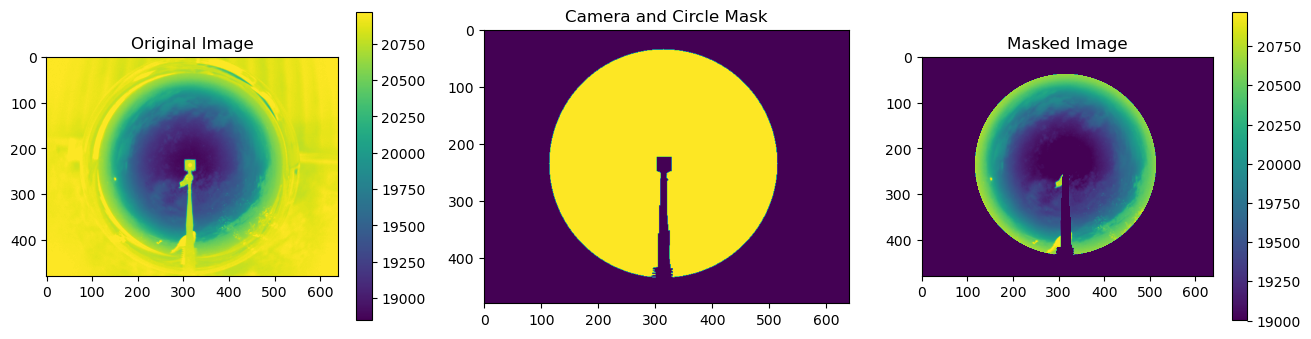

In [7]:
# Load image
filepath = '20230807/20230807121300.jp2'
image = imageio.imread(filepath)
gauss = gaussian(image, sigma=20)*2**16-1
image[image>np.max(gauss)]=np.max(gauss)

def white_circle(slicee):
    shape = (480,640); center = (235, 314); radius = cutoff_radius
    y, x = np.ogrid[:shape[0], :shape[1]]
    circle = (x - center[1]) ** 2 + (y - center[0]) ** 2 <= radius ** 2
    circle_image = circle * slicee
    return circle_image
# # camera mask is multiplied to the image to make it the darkest part of it by -1
camara = Image.open('camera.png')
camara = np.asarray(camara)
# Only the alpha channel is needed, and is divided by 255 to get the number in the range [0,1]
slicee = camara[:,:,3]/255
cutoff_radius = 200
circle = white_circle(slicee).astype(int)
slicee = slicee.astype(bool)
mask_circ = circle > 0

plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.imshow(image)
plt.colorbar()
plt.title('Original Image')

plt.subplot(1,3,2)
plt.imshow(mask_circ)
plt.title('Camera and Circle Mask')

plt.subplot(1,3,3)
plt.imshow(mask_circ*image, vmin=19000)
plt.colorbar()
plt.title('Masked Image')


To remove the birds a rectangular area around the stick gets defined. 

Text(0.5, 1.0, 'Local Win=53')

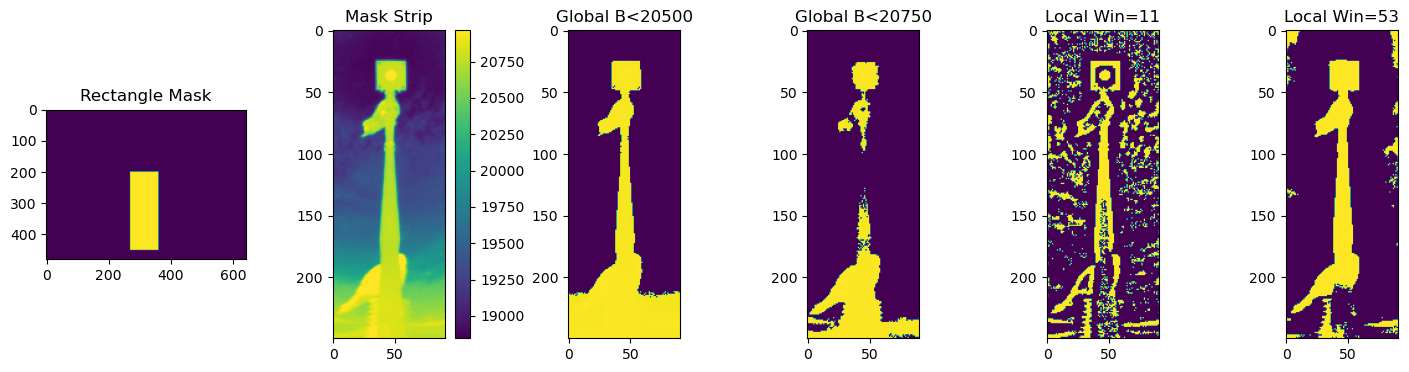

In [8]:
## bird removal
inv_mask = slicee == 0
region_values = image[inv_mask]
mean_value = np.mean(region_values)
# print(mean_value)
# Parameters for the rectangle
image_size = image.shape
width = 90; height = 250
top_left = (314-width/2, 200)
bottom_right = (top_left[0] + width, top_left[1] + height)
y, x = np.ogrid[:image_size[0], :image_size[1]]
rectangle = (x >= top_left[0]) & (x <= bottom_right[0]) & (y >= top_left[1]) & (y <= bottom_right[1])
rectangle_image = np.zeros(image_size)
rectangle_image[rectangle] = 1
rectangle_data = rectangle_image*image
strip = rectangle_data[200:450,269:360]

plt.figure(figsize=(18,4))
plt.subplot(1,6,1)
plt.imshow(rectangle_image)
plt.title('Rectangle Mask')

plt.subplot(1,6,2)
plt.imshow(strip)
plt.title('Mask Strip')
plt.colorbar()

dumb_seg = strip < 20500
plt.subplot(1,6,3)
plt.imshow(~dumb_seg*strip)
plt.title('Global B<20500')

dumb_seg = strip < 20750
plt.subplot(1,6,4)
plt.imshow(~dumb_seg*strip)
plt.title('Global B<20750')

window_size=11
thresh  = threshold_niblack(strip, window_size=window_size, k=-0.4)
binary = strip > thresh
plt.subplot(1,6,5)
plt.imshow(binary)
plt.title('Local Win=11')

window_size=53
thresh  = threshold_niblack(strip, window_size=window_size, k=-0.6)
binary = strip > thresh
plt.subplot(1,6,6)
plt.imshow(binary)
plt.title('Local Win=53')


A regular global segmentation can be applied. What this does is finding a cutoff brightness to filter the image. No matter the algorithm for this type of image with increasing brightness in the bottom the result will always have compromises. Cuting from a lower value removes more than desired, while cuting from a higher value removes more than desired and also leaves parts that should also be removed, so no matter the threshold value the result will not be ideal, also, since the images come with varying brightness depending on external conditions finding the sweetspot becomes a nightmare for a large dataset. Local thresholding on the other hand presents a better solution as it performs its procedure on smaller chunks of the image, defined by a window size. The `K` parameter weights the effect of the standard deviation. This procedure is much more manageable than the global thresholding procedure, the result should then be adjusted to remove small areas. 

A different approach was found however and with this one the varying brightness gets fixed by root, making the thresholding algorithms have an easier time, and giving even more reliable results. It consists of dividing the image in different horinzontal pixel lines, and averaging the brightness on each. As expected the average brightenss increases as we go down on the image. This is a recurrent effect on all the images from the skycam. By subtracting the average of each line (and 5% of the standard deviation) the resulting images are much more cleaner and a global thresholding technique suffices. 

Text(0.5, 1.0, 'Bird Mask')

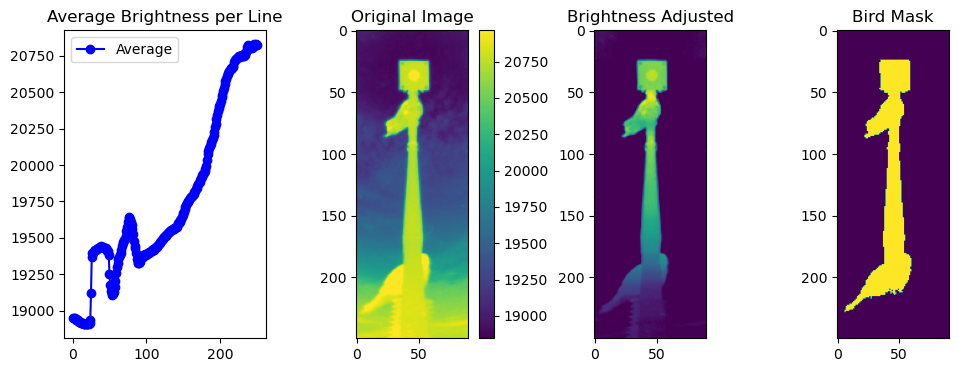

In [9]:
average_brightness_list = []
average_std_list = []
for y in range(height):
    row_pixels = strip[y, :]
    average_brightness = np.mean(row_pixels)
    average_brightness_list.append(average_brightness)
    average_std = np.std(row_pixels)
    average_std_list.append(average_std)
    
for y in range(height):
    strip[y, :] -= average_brightness_list[y] + average_std_list[y]*0.05
    strip[y, :] = np.clip(strip[y, :], 0, None)

def remove_small(slc, c=0.0001):
    new_slc = slc.copy()
    labels = label(slc,connectivity=1,background=0)
    rps = regionprops(labels)
    areas = np.array([r.area for r in rps])
    idxs = np.where(areas/(640*480) < c)[0]
    for i in idxs:
        new_slc[tuple(rps[i].coords.T)] = 0
    return new_slc
  
thresh  = threshold_yen(strip)
binary = strip > thresh
big_mask = remove_small(binary, c=0.005)
bird_mask = rectangle_data*0
bird_mask[200:450,269:360] = big_mask

plt.figure(figsize=(12,4))
plt.subplot(1,4,1)
plt.plot(range(1, 250 + 1), average_brightness_list, marker='o', linestyle='-', color='b', label='Average')
plt.legend()
plt.title('Average Brightness per Line')

im = rectangle_image*image
plt.subplot(1,4,2)
plt.imshow(im[200:450,269:360])
plt.title('Original Image')
plt.colorbar()

plt.subplot(1,4,3)
plt.imshow(strip)
plt.title('Brightness Adjusted')


plt.subplot(1,4,4)
plt.imshow(big_mask)
plt.title('Bird Mask')


The resulting bird mask can now be added to the previously defined stick and circle masks.

Text(0.5, 1.0, 'Masked Image')

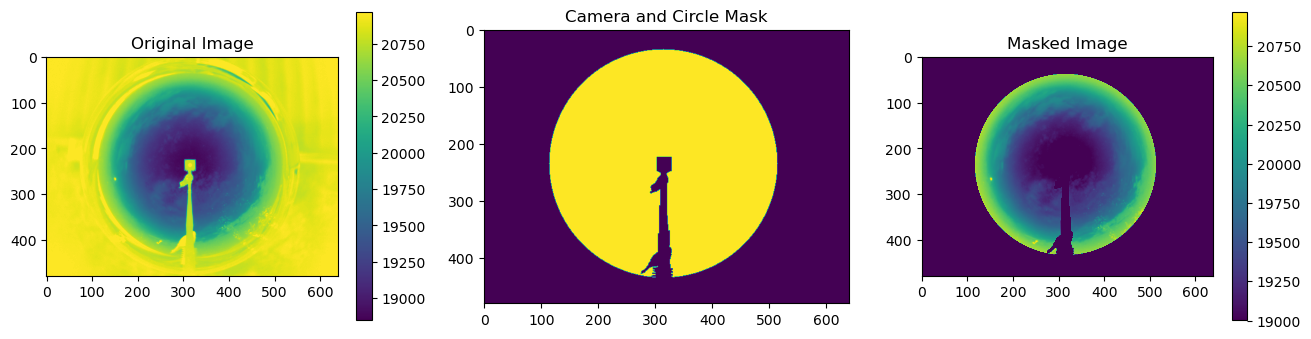

In [10]:
bird_mask = (bird_mask > 0).astype(bool)


final_mask = ~bird_mask & mask_circ

plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.imshow(image)
plt.colorbar()
plt.title('Original Image')

plt.subplot(1,3,2)
plt.imshow(final_mask)
plt.title('Camera and Circle Mask')

plt.subplot(1,3,3)
plt.imshow(final_mask*image, vmin=19000)
plt.colorbar()
plt.title('Masked Image')

Since the approach for adjusting brightness based on average worked well 

c:\Users\rodhe\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\rodhe\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\rodhe\anaconda3\lib\site-packages\numpy\core\_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\rodhe\anaconda3\lib\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
c:\Users\rodhe\anaconda3\lib\site-packages\numpy\core\_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\rodhe\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice


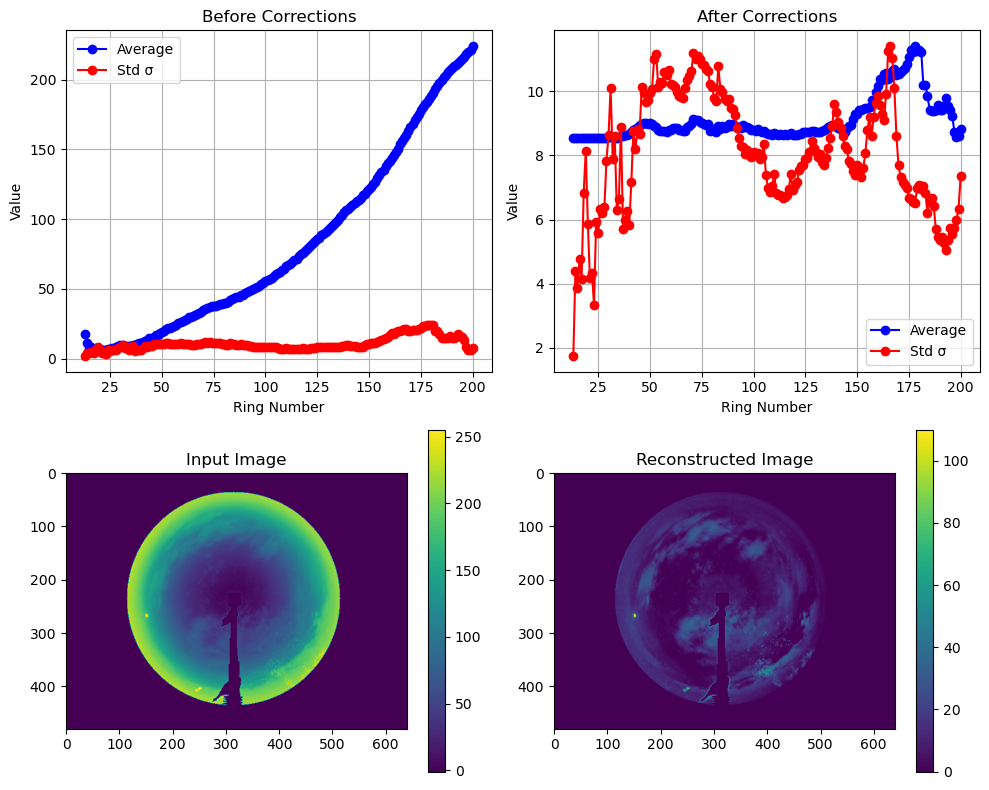

In [11]:
def rings (img, cutoff_radius, center):
    only_circle = img
    # Create a meshgrid of coordinates
    y, x = np.ogrid[:only_circle.shape[0], :only_circle.shape[1]]
    # Calculate the distance of each pixel from the center
    distance_map = np.sqrt((x - center[1])**2 + (y - center[0])**2)
    # Create an array to store the average values for each ring
    average_values = np.zeros(cutoff_radius)
    std_dev_values = np.zeros(cutoff_radius)
    var_values = np.zeros(cutoff_radius)
    # Create a list to store pixel values and their coordinates
    pixel_values_and_coords = []
    
    # Iterate over each ring and store pixel values and coordinates, excluding masked values
    for r in range(1, cutoff_radius+1):
        ring_pixels = np.logical_and(distance_map >= r - 1, distance_map < r)
        ring_pixels = np.logical_and(ring_pixels, slicee)  # Apply the mask
        # Get the coordinates of pixels in the ring
        ring_coords = np.column_stack(np.where(ring_pixels))
        # Get the pixel values in the ring
        ring_values = only_circle[ring_pixels]
        # Calculate the average value for the current ring
        average_values[r - 1] = np.mean(ring_values)
        std_dev_values[r - 1] = np.std(ring_values)
        var_values[r - 1] = np.var(ring_values)
        # Append pixel values and coordinates to the list
        pixel_values_and_coords.append((ring_values, ring_coords))
    return pixel_values_and_coords, average_values, std_dev_values, var_values

# Image gets converted to int32
int_img = image.astype(int)
img = int_img * slicee
img[img<1000] = np.max(np.min(int_img) - 1, 0)
only_circle = ((img- np.min(img)) /
                (np.max(img) - np.min(img)) * 2**8-1)*final_mask

center = (235, 314)
pixel_values_and_coords, average_values, std_dev_values, var_values = rings (only_circle, cutoff_radius, center)

# Find the average value of ring 15
reference_average_value = average_values[15] 

# # Apply corrections on every ring
for i in range(len(pixel_values_and_coords)):
    ring_data = pixel_values_and_coords[i]
    correction_value = reference_average_value - average_values[i]
    # Subtract the correction value and set negative values to zero
    corrected_ring_values = np.maximum(0, ring_data[0] + correction_value)
    pixel_values_and_coords[i] = (corrected_ring_values, ring_data[1])

# Reconstruct the image
reconstructed_image = np.zeros_like(only_circle)
for ring_data in pixel_values_and_coords:
    ring_values, ring_coords = ring_data
    reconstructed_image[ring_coords[:, 0], ring_coords[:, 1]] = ring_values

# Compute and plot new average values after corrections
new_average_values = np.zeros(cutoff_radius)
new_std_values = np.zeros(cutoff_radius)
for i in range(len(pixel_values_and_coords)):
    new_average_values[i] = np.mean(pixel_values_and_coords[i][0])
    new_std_values[i] = np.std(pixel_values_and_coords[i][0])
    
# # Plot the average values before corrections
plt.figure(figsize=(10,8))
plt.subplot(2, 2, 1)
plt.plot(range(1, cutoff_radius + 1), average_values, marker='o', linestyle='-', color='b', label='Average')
plt.plot(range(1, cutoff_radius + 1), std_dev_values, marker='o', linestyle='-', color='r', label='Std σ')
plt.legend()
plt.grid(True)
plt.title('Before Corrections')
plt.xlabel('Ring Number')
plt.ylabel('Value')

plt.subplot(2, 2, 2)
plt.plot(range(1, cutoff_radius+1), new_average_values, marker='o', linestyle='-', color='b', label='Average')
plt.plot(range(1, cutoff_radius+1), new_std_values, marker='o', linestyle='-', color='r', label='Std σ')
plt.legend()
plt.title('After Corrections')
plt.xlabel('Ring Number')
plt.ylabel('Value')
plt.grid(True)

# Display the original input image
plt.subplot(2, 2, 3)
plt.imshow(only_circle)
plt.title('Input Image')
plt.colorbar()

# Display the reconstructed image
plt.subplot(2, 2, 4)
plt.imshow(reconstructed_image)
plt.title('Reconstructed Image')
plt.colorbar()

plt.tight_layout()
# plt.show()

sun_minor_clouds
Average: 19.136914230297744
Standard deviation: 2.7376008738845083
Variance: 7.494458544693225


<Figure size 640x480 with 0 Axes>

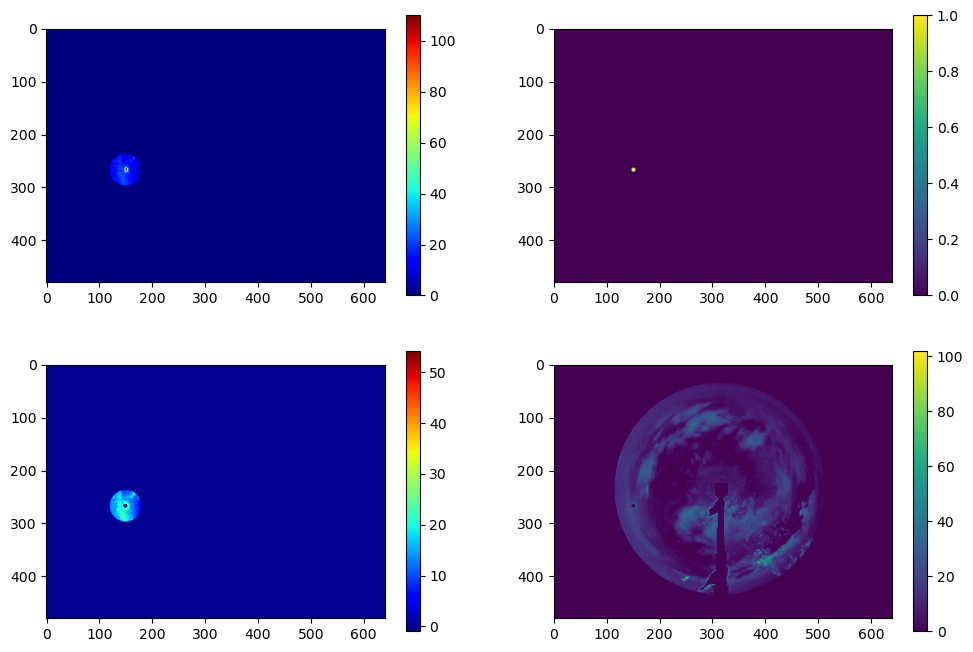

In [12]:
x_mapped, y_mapped, day = solar_pos(filepath)
timer = get_time (filepath)
solar_x, solar_y, covered = solar_xy (timer, x_mapped, y_mapped, day)

new_solar_x = poly_x(solar_x)
new_solar_y = poly_y(solar_y)


## Define circle around sun position
sun_values_and_coords, sun_avg, sun_std, sun_var = rings (reconstructed_image, 30, (new_solar_y, new_solar_x))

sun_circle = np.zeros_like(reconstructed_image)
for ring_data in sun_values_and_coords:
    ring_values, ring_coords = ring_data
    sun_circle[ring_coords[:, 0], ring_coords[:, 1]] = ring_values


# Calculate the "derivative" or differences between consecutive averages
percentage_max = sun_avg/(np.max(sun_avg))*100
differences = np.diff(percentage_max)
second_d = np.diff(differences)
# Find local maxima indices
local_maxima_indices = np.where((differences[:-1] > 0) & (differences[1:] < 0))[0] + 1
# no_sun = sun_values_and_coords
no_sun = copy.deepcopy(sun_values_and_coords)
if np.max(percentage_max) in percentage_max[0:6]:
    flag = 'sun'
    if (np.mean(percentage_max[6:]) < 10)&(np.std(percentage_max[6:])<6):
        flag = 'sun_no_clouds'
    if (np.mean(percentage_max[6:]) > 10)&(np.std(percentage_max[6:])<6):
        flag = 'sun_minor_clouds'
    if (np.mean(percentage_max[6:]) > 50)&(np.std(percentage_max[6:])<9):
        flag = 'sun_major_clouds'
    if any(i > 80 for i in percentage_max[6:]): 
        flag = 'cloudy_around_sun'   
else:
    flag = 'sun_covered'

for n in range(0, 7):
    if (percentage_max[n]>50)&((flag=='sun_no_clouds')|(flag=='sun_minor_clouds')|(flag=='sun_major_clouds')):
        no_sun[n][0][:] = -1

print(flag)
print('Average: ' + str(np.mean(percentage_max[6:])))
print('Standard deviation: ' + str(np.std(percentage_max[6:])))
print('Variance: ' + str(np.var(percentage_max[6:])))

sun_img = np.zeros_like(reconstructed_image)
for ring_data in no_sun:
    ring_values, ring_coords = ring_data
    sun_img[ring_coords[:, 0], ring_coords[:, 1]] = ring_values

plt.clf()
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.imshow(sun_circle, cmap = 'jet')
plt.colorbar()

plt.subplot(2,2,3)
plt.imshow(sun_img, cmap = 'jet')
plt.colorbar()

sun_mask = sun_img == -1
no_sun_image = ~sun_mask*reconstructed_image
# no_sun_image = reconstructed_image
plt.subplot(2,2,2)
plt.imshow(sun_mask)
plt.colorbar()

plt.subplot(2,2,4)
plt.imshow(no_sun_image)
plt.colorbar()

The next step is to generate the radial gradients to multiply with the input image. This multiplication was done with the library blend modes. The library only accepts RGBA images as input, the current image is a single channel only, so the RGB layers are duplicates of this channel and the alpha layer is set to a constant opaque layer of ones. For this step the image itself was rescaled to be in the range of `[0,255]`, this step makes it lose some data from the original image that was in the 16-bit range, however it is neccesary as some functions only take as input images in the 8-bit range per channel.

(480, 640, 4)


Text(0.5, 1.0, 'Alpha channel')

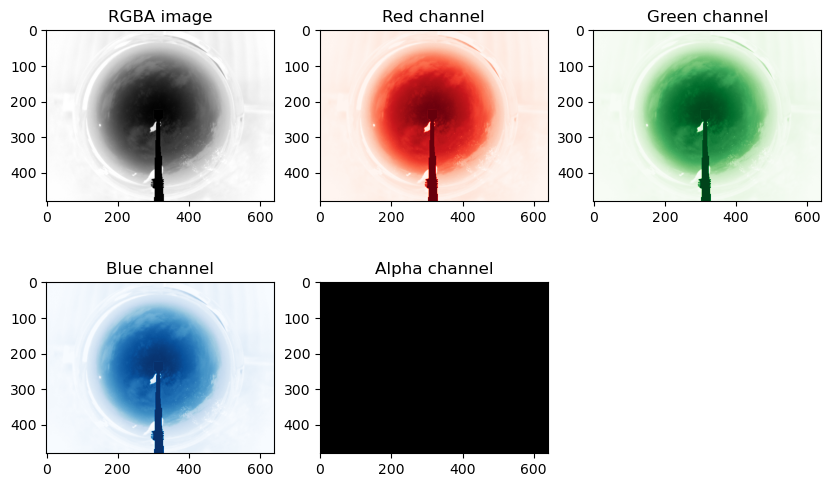

In [13]:
# The following function can be used to generate an RGBA image
def TwoDToRGBA (img):
    # Inputs to blend_modes need to be numpy arrays.
    background_img = np.array(img)  
    # Rescale the pixel values to the range [0, 255]
    scaled_img = ((background_img - np.min(background_img)) / (np.max(background_img) - np.min(background_img)) * 255).astype(np.uint8)
    # Creates an RGBA zeros image with the rescaled content
    rgba_image = np.zeros((background_img.shape[0], background_img.shape[1], 4), dtype=np.uint8)
    # The rescaled values get copied to every channel
    rgba_image[:, :, 0:3] = scaled_img[:, :, np.newaxis]
    # The alpha channel is set to a constant value of 255, for a fully opaque channel
    alpha_value = 255
    rgba_image[:, :, 3] = alpha_value
    # Now 'rgba_image' is an RGBA image with dimensions (~, ~, 4)
    return rgba_image

rgba_image = TwoDToRGBA (img)
print(rgba_image.shape)

plt.figure(figsize=(10,6))
plt.subplot(2, 3, 1)
plt.imshow(rgba_image)
plt.title("RGBA image")

plt.subplot(2, 3, 2)
plt.imshow(rgba_image[:,:,0], cmap="Reds_r")
plt.title("Red channel")

plt.subplot(2, 3, 3)
plt.imshow(rgba_image[:,:,1], cmap="Greens_r")
plt.title("Green channel")

plt.subplot(2, 3, 4)
plt.imshow(rgba_image[:,:,2], cmap="Blues_r")
plt.title("Blue channel")

plt.subplot(2, 3, 5)
plt.imshow(rgba_image[:,:,3], cmap="gray")
plt.title("Alpha channel")



In [14]:
import blend_modes

def create_radial_gradient(size, center, radius):

    y, x = np.ogrid[:size[0], :size[1]]
    distance = np.sqrt((x - center[1]) ** 2 + (y - center[0]) ** 2)
    gradient = 1 - np.clip(distance / radius, 0, 1)
    return gradient

def multiply_with_gradient(image, gradient, opacity):
    # Inputs to blend_modes need to be floats.
    background_img_float = image.astype(float)
    foreground_img_float = gradient.astype(float)
    blended_img_float = blend_modes.multiply(background_img_float, foreground_img_float, opacity)

    # Convert blended image back into PIL image
    blended_img = np.uint8(blended_img_float)  # Image needs to be converted back to uint8 type for PIL handling.
    # blended_img_raw = Image.fromarray(blended_img)  # Note that alpha channels are displayed in black by PIL by default.
    return blended_img

rgba_image = TwoDToRGBA (no_sun_image)
image_size = rgba_image.shape
gradient_center = (235, 314)  # Center of the gradient correponding to the center of the camera
gradient_radius = 210  # Radius of the gradient

gradient_1 = create_radial_gradient(image_size, gradient_center, gradient_radius)
rgba_grad_1 = TwoDToRGBA (gradient_1)
gradient_radius = 250  # Radius of the gradient
gradient_2 = create_radial_gradient(image_size, gradient_center, gradient_radius)
rgba_grad_2 = TwoDToRGBA (gradient_2)

first_grad = multiply_with_gradient(rgba_image, rgba_grad_1, 1)
# second_grad = multiply_with_gradient(first_grad, rgba_grad_2, 1)


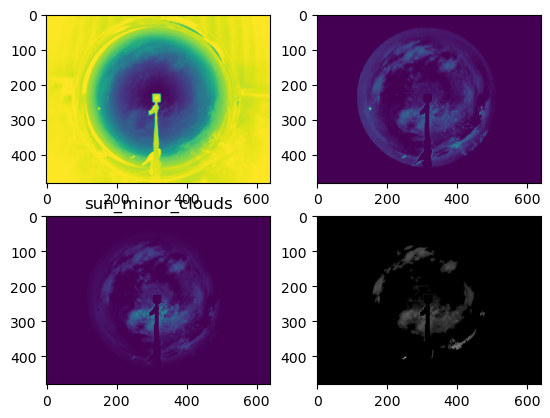

In [15]:
from skimage.filters import threshold_yen, gaussian

gauss = gaussian(first_grad[:,:,0], sigma=0.5)
no_sun_image = ((gauss - np.min(gauss)) / (np.max(gauss) - np.min(gauss)) * 2**16-1)*mask_circ

thresh  = threshold_otsu(no_sun_image)
binary = no_sun_image > thresh

big_mask = remove_small(binary)
label_big_mask = label(big_mask)
big_clouds = rgba_image[:, :, 0] * big_mask * mask_circ * ~sun_mask

def TwoDToRGB(img):
    background_img = np.array(img)
    # Rescale the pixel values to the range [0, 255]
    scaled_img = ((background_img - np.min(background_img)) / (np.max(background_img) - np.min(background_img)) * 255).astype(np.uint8)
    # Create an RGB image with the rescaled content
    rgb_image = np.zeros((background_img.shape[0], background_img.shape[1], 3), dtype=np.uint8)
    # Copy the rescaled values to all three channels (RGB)
    rgb_image[:, :, :] = scaled_img[:, :, np.newaxis]
    # Now 'rgb_image' is an RGB image with dimensions (height, width, 3)
    return rgb_image

# For ease of use the single channel image gets converted to RGB (similar to the RGBA process)
output_img = TwoDToRGB(big_clouds)
plt.clf()
plt.subplot(2,2,1)
plt.imshow(image)

plt.subplot(2,2,2)
plt.imshow(reconstructed_image)

plt.subplot(2,2,3)
plt.imshow(no_sun_image)
plt.title(flag)

plt.subplot(2,2,4)
plt.imshow(output_img)


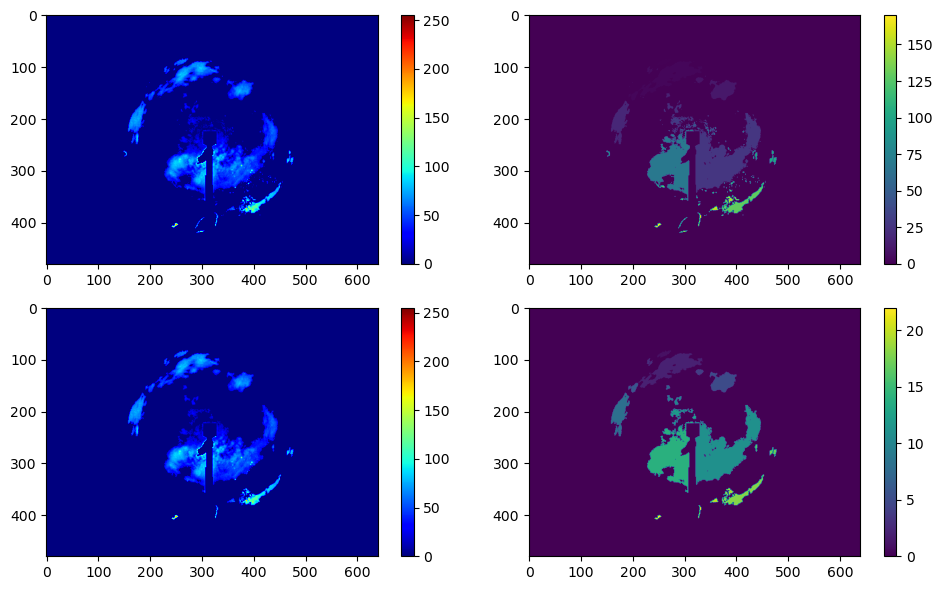

In [16]:
from skimage.measure import label, regionprops
clouds = rgba_image[:,:,0]*binary
cloud_mask= label(binary)

big_mask = remove_small(binary)
label_big_mask = label(big_mask)
big_clouds = rgba_image[:,:,0]*big_mask


plt.figure(figsize=(10,6))
plt.subplot(2,2,1)
plt.imshow(clouds, cmap='jet', vmin=0, vmax=255)
plt.colorbar()

plt.subplot(2,2,2)
plt.imshow(cloud_mask)
plt.tight_layout()
plt.colorbar()

plt.subplot(2,2,3)
plt.imshow(big_clouds, cmap='jet', vmin=0, vmax=255)
plt.colorbar()

plt.subplot(2,2,4)
plt.imshow(label_big_mask)
plt.tight_layout()
plt.colorbar()



The whole process until now to load an image and segment it can be done in a single function. This will be useful for steps below and to implement a single code for the whole feature extraction process. 

Text(0.5, 1.0, 'sun_minor_clouds')

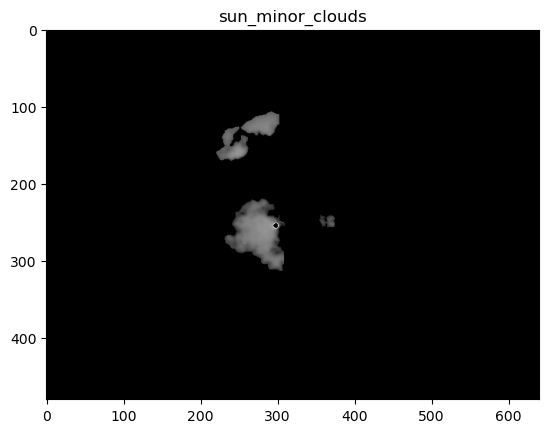

In [17]:
import imageio.v2 as imageio
from PIL import Image, ImageDraw
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import *
from skimage.metrics import *
from skimage.segmentation import *
from skimage.feature import *
from skimage.measure import label, regionprops
from scipy import ndimage as ndi
from scipy.interpolate import *
import pvlib
import copy
import pandas as pd
import blend_modes
import warnings
import os
warnings.simplefilter(action='ignore', category=FutureWarning)

# path to jp2 image
# filepath = '20230807/20230807110400.jp2'
# filepath = '20230807/20230807131700.jp2'
# filepath = '20230807/20230807121300.jp2'
# filepath = '20230807/20230807180600.jp2'
# filepath = '20230807/20230807100230.jp2'
# filepath = '20230807/20230807163300.jp2'
# filepath = '20230807/20230807152030.jp2'
# filepath = '20230807/20230807192300.jp2'
# filepath = '20230808/20230808192300.jp2'




# filepath = '20230808/20230808112930.jp2'
# filepath = '20230808/20230808131100.jp2'
# filepath = '20230808/20230808140700.jp2'
# filepath = '20230808/20230808153730.jp2'
# filepath = '20230808/20230808162300.jp2'
# filepath = '20230808/20230808175830.jp2'
# filepath = '20230808/20230808190630.jp2'
# filepath = '20230808/20230808200130.jp2'
# filepath = '20230808/20230808201030.jp2'
# filepath = '20230808/20230808213400.jp2'



def normalize_img(img):
    gauss = gaussian(img, sigma=20)*2**16-1
    img[img>np.max(gauss)]=np.max(gauss)
    return img
def TwoDToRGBA (img):
    background_img = np.array(img)  
    # Rescale the pixel values to the range [0, 255]
    scaled_img = ((background_img - np.min(background_img)) / (np.max(background_img) - np.min(background_img)) * 255).astype(np.uint8)
    # Creates an RGBA zeros image with the rescaled content
    rgba_image = np.zeros((background_img.shape[0], background_img.shape[1], 4), dtype=np.uint8)
    # The rescaled values get copied to every channel
    rgba_image[:, :, 0:3] = scaled_img[:, :, np.newaxis]
    # The alpha channel is set to a constant value of 255, for a fully opaque channel
    alpha_value = 255
    rgba_image[:, :, 3] = alpha_value
    # Now 'rgba_image' is an RGBA image with dimensions (~, ~, 4)
    return rgba_image
def TwoDToRGB(img):
    background_img = np.array(img)
    # Rescale the pixel values to the range [0, 255]
    scaled_img = ((background_img - np.min(background_img)) / (np.max(background_img) - np.min(background_img)) * 255).astype(np.uint8)
    # Create an RGB image with the rescaled content
    rgb_image = np.zeros((background_img.shape[0], background_img.shape[1], 3), dtype=np.uint8)
    # Copy the rescaled values to all three channels (RGB)
    rgb_image[:, :, :] = scaled_img[:, :, np.newaxis]
    # Now 'rgb_image' is an RGB image with dimensions (height, width, 3)
    return rgb_image
def remove_small(slc, c=0.0001):
    new_slc = slc.copy()
    labels = label(slc,connectivity=1,background=0)
    rps = regionprops(labels)
    areas = np.array([r.area for r in rps])
    idxs = np.where(areas/(640*480) < c)[0]
    for i in idxs:
        new_slc[tuple(rps[i].coords.T)] = 0
    return new_slc
def create_radial_gradient(size, center, radius):
    y, x = np.ogrid[:size[0], :size[1]]
    distance = np.sqrt((x - center[1]) ** 2 + (y - center[0]) ** 2)
    gradient = 1 - np.clip(distance / radius, 0, 1)
    return gradient
def multiply_with_gradient(image, gradient, opacity):
    background_img_float = image.astype(float)
    foreground_img_float = gradient.astype(float)
    blended_img_float = blend_modes.multiply(background_img_float, foreground_img_float, opacity)
    # Convert blended image back into PIL image
    blended_img = np.uint8(blended_img_float)
    return blended_img
# White circle to mask camera
def white_circle(slicee, cutoff_radius = 200):
    shape = (480,640); center = (235, 314); radius = cutoff_radius
    y, x = np.ogrid[:shape[0], :shape[1]]
    circle = (x - center[1]) ** 2 + (y - center[0]) ** 2 <= radius ** 2
    circle_image = circle * slicee
    return circle_image
def solar_pos(filepath):
    
    tz = 'America/Bogota'
    lat, lon = 9.789103, -73.722451 # 9.789103, -73.722451 Esta es las coordenas
    altitude = 50

    #Ubicación Geográfica
    location = pvlib.location.Location(lat, lon, tz, altitude)
    times = pd.date_range('2023-01-01 00:00:00', '2024-12-31', closed='left',
                          freq='H', tz=tz)
    solpos = pvlib.solarposition.get_solarposition(times, lat, lon)
    # remove nighttime
    solpos = solpos.loc[solpos['apparent_elevation'] > 0, :]
    # draw hour labels
    for hour in np.unique(solpos.index.hour):
        # choose label position by the smallest radius for each hour
        subset = solpos.loc[solpos.index.hour == hour, :]
        r = subset.apparent_zenith
        pos = solpos.loc[r.idxmin(), :]
        # ax.text(np.radians(pos['azimuth']), pos['apparent_zenith'], str(hour))
    YY = filepath[-18:-14]
    MM = filepath[-14:-12]
    DD = filepath[-12:-10]
    day = YY+'-'+MM+'-'+DD
    # draw individual days
    for date in pd.to_datetime([day]):
        times = pd.date_range(date, date+pd.Timedelta('24h'), freq='30s', tz=tz)
        solpos = pvlib.solarposition.get_solarposition(times, lat, lon)
        solpos = solpos.loc[solpos['apparent_elevation'] > 0, :]
        label = date.strftime('%Y-%m-%d')
        azimuth_radians = np.radians(solpos.azimuth)

    # Convert polar coordinates to Cartesian coordinates
    x_direct = solpos.apparent_zenith * np.sin(azimuth_radians)
    y_direct = solpos.apparent_zenith * np.cos(azimuth_radians)

    x = -(x_direct)*3.18+312
    y =  y_direct*2 + 238
    
    # Rotate about center 3.5 degrees
    x_c = 314; y_c = 235; j_rot = np.deg2rad(3.5)
    x_rot = (x - x_c)* np.cos(j_rot)- (y-y_c)*np.sin(j_rot) + x_c
    y_rot = (x - x_c)* np.sin(j_rot)+ (y-y_c)*np.cos(j_rot) + y_c

    # Reflect about x axis
    x_final = x_rot
    y_final = -y_rot + 478

    return x_final, y_final, day

# gets the time from the filepath following the convention '~/YYYYMMDDhhmmss.png'
def get_time (filepath):
    st = filepath[-10:-4]
    hh = str(int(st[0:2])-5)
    if len(hh) == 1:
        hh = '0'+hh
    mm = st[2:4]
    ss = st[4:6]
    timer = hh + ':'+ mm + ':' + ss  
    return timer

def get_solar_coords (x_mapped, y_mapped, day, timer):
    x = x_mapped[day + ' ' + timer + '-05:00']
    y = y_mapped[day + ' ' + timer + '-05:00']
    return x, y

def solar_xy (timer, x_mapped, y_mapped, day):
    if int(timer[:-6]) <5:
        timer = '05:47:00'
        solar_x, solar_y =  get_solar_coords (x_mapped, y_mapped, day, timer)
        solar_y =solar_y
        covered = 'No sun'
    if (int(timer[:-6]) ==5)&(int(timer[-5:-3])<47):
        timer = '05:47:00'
        solar_x, solar_y =  get_solar_coords (x_mapped, y_mapped, day, timer)
        solar_y = solar_y
        covered = 'No sun'
    else:    
        solar_x, solar_y =  get_solar_coords (x_mapped, y_mapped, day, timer)
        solar_y = solar_y
        covered = 'say if yes or no'
    return solar_x, solar_y, covered

# Solar pos calibration 
def solar_calibration():
    # Load image
    solar_image = Image.open('solar_pos.png')
    solar_image = np.asarray(solar_image)
    
    calibration_images = [20230808112930, 20230808131100, 20230808140700, 20230808153730, 20230808162300,
                          20230808175830, 20230808190630, 20230808200130, 20230808213400]
    
    x_m = np.array([])
    y_m = np.array([])
    for im in calibration_images:
        im = str(im)
        img_s = im + '.jp2'
        # get the solar coords for image comparison
        x_mapped, y_mapped, day = solar_pos(img_s)
        timer = get_time (img_s)
        solar_x, solar_y, covered = solar_xy (timer, x_mapped, y_mapped, day)
        x_m = np.append(x_m, solar_x)
        y_m = np.append(y_m, solar_y)
        
    
    # Real data
    x_real = np.array([132, 178, 207, 262, 290, 354, 395.5, 427, 471.5])
    y_real = np.array([270, 258, 255.245, 252, 253, 257.978, 262.268, 272, 282.172])
    
    # Polynomial regression
    degree = 3  # degree of the polynomial
    coefficients_x = np.polyfit(x_m, x_real, degree)
    coefficients_y = np.polyfit(y_m, y_real, degree)
    poly_x = np.poly1d(coefficients_x)
    poly_y = np.poly1d(coefficients_y)
    return poly_x, poly_y

def rings (img, slicee,cutoff_radius=200, center=(235,314)):
    only_circle = img
    # Create a meshgrid of coordinates
    y, x = np.ogrid[:only_circle.shape[0], :only_circle.shape[1]]
    # Calculate the distance of each pixel from the center
    distance_map = np.sqrt((x - center[1])**2 + (y - center[0])**2)
    # Create an array to store the average values for each ring
    average_values = np.zeros(cutoff_radius)
    std_dev_values = np.zeros(cutoff_radius)
    var_values = np.zeros(cutoff_radius)
    # Create a list to store pixel values and their coordinates
    pixel_values_and_coords = []
    
    # Iterate over each ring and store pixel values and coordinates, excluding masked values
    for r in range(1, cutoff_radius+1):
        ring_pixels = np.logical_and(distance_map >= r - 1, distance_map < r)
        ring_pixels = np.logical_and(ring_pixels, slicee)  # Apply the mask
        # Get the coordinates of pixels in the ring
        ring_coords = np.column_stack(np.where(ring_pixels))
        # Get the pixel values in the ring
        ring_values = only_circle[ring_pixels]
        # Calculate the average value for the current ring
        if ring_values.shape[0] != 0:
            average_values[r - 1] = np.mean(ring_values)
            std_dev_values[r - 1] = np.std(ring_values)
            var_values[r - 1] = np.var(ring_values)
        # Append pixel values and coordinates to the list
        pixel_values_and_coords.append((ring_values, ring_coords))
    return pixel_values_and_coords, average_values, std_dev_values, var_values

def segmentation (filepath):
    # # camera mask is multiplied to the image to make it the darkest part of it by -1
    camara = Image.open('camera.png')
    camara = np.asarray(camara)
    # Only the alpha channel is needed, and is divided by 255 to get the number in the range [0,1]
    slicee = camara[:,:,3]/255
    cutoff_radius = 200
    circle = white_circle(slicee).astype(int)
    slicee = slicee.astype(bool)
    mask_circ = circle > 0


    # Load image
    image = imageio.imread(filepath)
    gauss = gaussian(image, sigma=20)*2**16-1
    image[image>np.max(gauss)]=np.max(gauss)


    ## bird removal
    inv_mask = slicee == 0
    region_values = image[inv_mask]
    mean_value = np.mean(region_values)
    # print(mean_value)
    # Parameters for the rectangle
    image_size = image.shape
    width = 75; height = 250
    top_left = (314-width/2, 200)
    bottom_right = (top_left[0] + width, top_left[1] + height)
    y, x = np.ogrid[:image_size[0], :image_size[1]]
    rectangle = (x >= top_left[0]) & (x <= bottom_right[0]) & (y >= top_left[1]) & (y <= bottom_right[1])
    rectangle_image = np.zeros(image_size)
    rectangle_image[rectangle] = 1
    rectangle_data = rectangle_image*image
    strip = rectangle_data[200:450,277:352]

    average_brightness_list = []
    average_std_list = []
    for y in range(height):
        row_pixels = strip[y, :]
        average_brightness = np.mean(row_pixels)
        average_brightness_list.append(average_brightness)
        average_std = np.std(row_pixels)
        average_std_list.append(average_std)
        
    for y in range(height):
        strip[y, :] -= average_brightness_list[y] + average_std_list[y]*0.05
        strip[y, :] = np.clip(strip[y, :], 0, None)
        
    thresh  = threshold_yen(strip)
    binary = strip > thresh
    big_mask = remove_small(binary, c=0.005)
    bird_mask = rectangle_data*0
    bird_mask[200:450,277:352] = big_mask
    bird_mask = (bird_mask > 0).astype(bool)
    final_mask = ~bird_mask & mask_circ

    # Image gets converted to int32
    int_img = image.astype(int)
    img = int_img * slicee
    img[img<1000] = np.max(np.min(int_img) - 1, 0)
    only_circle = ((img- np.min(img)) /
                    (np.max(img) - np.min(img)) * 2**16-1)*final_mask
    center = (235, 314)
    pixel_values_and_coords, average_values, std_dev_values, var_values = rings (only_circle, slicee,cutoff_radius, center)
    # Find the average value of ring 70
    reference_average_value = average_values[15] 
    # # Apply corrections on every ring basis
    for i in range(len(pixel_values_and_coords)):
        ring_data = pixel_values_and_coords[i]
        correction_value = reference_average_value - average_values[i]
        # Subtract the correction value and set negative values to zero
        corrected_ring_values = np.maximum(0, ring_data[0] + correction_value)
        pixel_values_and_coords[i] = (corrected_ring_values, ring_data[1])

    # Reconstruct the image
    reconstructed_image = np.zeros_like(only_circle)
    for ring_data in pixel_values_and_coords:
        ring_values, ring_coords = ring_data
        reconstructed_image[ring_coords[:, 0], ring_coords[:, 1]] = ring_values

    # Compute and plot new average values after corrections
    new_average_values = np.zeros(cutoff_radius)
    new_std_values = np.zeros(cutoff_radius)
    for i in range(len(pixel_values_and_coords)):
        ring_values = pixel_values_and_coords[i][0]
        if len(ring_values) > 0:
            new_average_values[i] = np.mean(ring_values)
            new_std_values[i] = np.std(ring_values)
        else:
            new_average_values[i] = 0
            new_std_values[i] = 0
        
    ## Define circle around sun position
    sun_values_and_coords, sun_avg, sun_std, sun_var = rings (reconstructed_image, slicee, 30, (new_solar_y, new_solar_x))

    # Calculate the differences between consecutive averages
    percentage_max = sun_avg/(np.max(sun_avg))*100
    # differences = np.diff(percentage_max)
    # second_d = np.diff(differences)
    # # Find local maxima indices
    # local_maxima_indices = np.where((differences[:-1] > 0) & (differences[1:] < 0))[0] + 1
    # no_sun = sun_values_and_coords
    no_sun = copy.deepcopy(sun_values_and_coords)
    if np.max(percentage_max) in percentage_max[0:6]:
        flag = 'sun'
        if (np.mean(percentage_max[6:]) < 10)&(np.std(percentage_max[6:])<6):
            flag = 'sun_no_clouds'
        if (np.mean(percentage_max[6:]) > 10)&(np.std(percentage_max[6:])<6):
            flag = 'sun_minor_clouds'
        if (np.mean(percentage_max[6:]) > 50)&(np.std(percentage_max[6:])<9):
            flag = 'sun_major_clouds'
        if any(i > 80 for i in percentage_max[6:]): 
            flag = 'cloudy_around_sun'   
    else:
        flag = 'sun_covered'

    for n in range(0, 5):
        if (percentage_max[n]>50)&((flag=='sun_no_clouds')|(flag=='sun_minor_clouds')|(flag=='sun_major_clouds')):
            no_sun[n][0][:] = -1

    # print(flag)

    sun_img = np.zeros_like(reconstructed_image)
    for ring_data in no_sun:
        ring_values, ring_coords = ring_data
        sun_img[ring_coords[:, 0], ring_coords[:, 1]] = ring_values

    sun_mask = sun_img == -1
    no_sun_image = ~sun_mask*reconstructed_image


    rgba_image = TwoDToRGBA (no_sun_image)
    image_size = rgba_image.shape
    gradient_center = (235, 314)  # Center of the gradient correponding to the center of the camera
    gradient_radius = 210  # Radius of the gradient
    gradient_1 = create_radial_gradient(image_size, gradient_center, gradient_radius)
    rgba_grad_1 = TwoDToRGBA (gradient_1)
    gradient_radius = 250  # Radius of the gradient
    # gradient_2 = create_radial_gradient(image_size, gradient_center, gradient_radius)
    # rgba_grad_2 = TwoDToRGBA (gradient_2)
    first_grad = multiply_with_gradient(rgba_image, rgba_grad_1, 1)
    # second_grad = multiply_with_gradient(first_grad, rgba_grad_2, 1)
    gauss = gaussian(first_grad[:,:,0], sigma=0.5)
    no_sun_image = ((gauss - np.min(gauss)) / (np.max(gauss) - np.min(gauss)) * 2**16-1)*mask_circ


    thresh  = threshold_otsu(no_sun_image)
    binary = no_sun_image > thresh

    big_mask = remove_small(binary)
    big_clouds = rgba_image[:, :, 0] * big_mask * mask_circ * ~sun_mask

    # For ease of use the single channel image gets converted to RGB (similar to the RGBA process)
    output_img = TwoDToRGB(big_clouds)
    return output_img, flag


filepath = '20230807/20230807163300.jp2'

poly_x, poly_y = solar_calibration()
x_mapped, y_mapped, day = solar_pos(filepath)
timer = get_time (filepath)
solar_x, solar_y, covered = solar_xy (timer, x_mapped, y_mapped, day)

new_solar_x = poly_x(solar_x)
new_solar_y = poly_y(solar_y)

output_img, flag = segmentation(filepath)


plt.clf()
plt.imshow(output_img)
plt.title(flag)




### 4. Optical Flow

Optical flow is used to determine the velocity in objects in an image, OpenCV has implemented two different algorithms for optical flow; the first one is Lucas-Kanade in a function called `calcOpticalFlowPyrLK()` that receives as inputs two consecutive images, and the points to be tracked. Given that the points are to be provided one aproach is using a border detection function as `goodFeaturesToTrack()` that determines the strong borders in an image based on Shi-Tomasi Corner Detection algorithm.

The other function is based on Farnebacks algorithm of optical flow, its called `calcOpticalFlowFarneback()` and referred to as "dense optical flow", the reason being that it calculates the velocity vector for every pixel in the image. 

https://docs.opencv.org/4.x/dc/d6b/group__video__track.html#ga473e4b886d0bcc6b65831eb88ed93323
https://docs.opencv.org/4.x/dc/d6b/group__video__track.html#ga5d10ebbd59fe09c5f650289ec0ece5af



The following code block is based on OpenCVs optical flow for the Lucas-Kanade implementation; in this case images from position 71 and 91 in the folder are analyzed, and a maximum of 100 points to track is set if detected by `goodFeaturesToTrack()`.

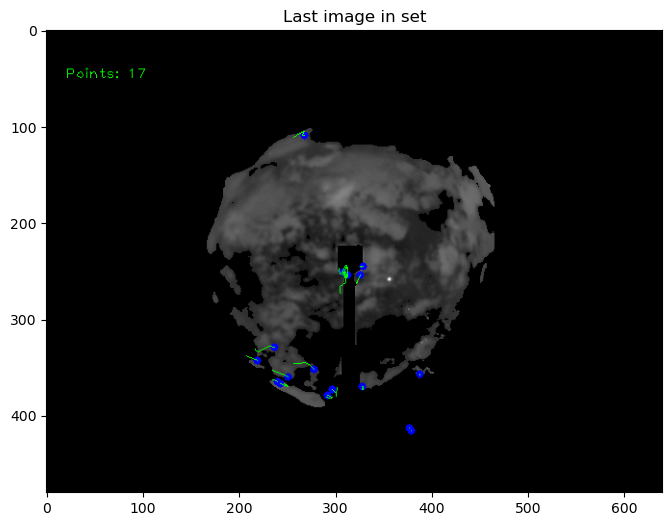

In [18]:
import os
import cv2

# Parameter definitos for LK optical flow and border detection
lk_params = dict(winSize=(15, 15),
                  maxLevel=2,
                  criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

feature_params = dict(maxCorners=100,
                      qualityLevel=0.3,
                      minDistance=10,
                      blockSize=7)

trajectory_len = 40
detect_interval = 5
trajectories = []
frame_idx = 0

# Specify the path to the folder containing images
image_folder = '20230807'

# Get the list of image files in the folder
image_files = sorted([f for f in os.listdir(image_folder) if f.endswith(('.jpg', '.png', '.jpeg', '.jp2'))])
# Read and preprocess the first image
first_im = os.path.join(image_folder, image_files[0])
prev_gray, prev_flag = segmentation(first_im)


for image_file in image_files[900:965]:
    # Construct the full path to the image
    image_path = os.path.join(image_folder, image_file)

    # Read and preprocess the image
    frame, flag = segmentation(image_path)
    # # If the images are already segmented use the command below
    # frame = cv2.imread(image_path)
    
    
    # Image gets transformed to single channel gray
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    lk_img = frame.copy()

    # Calculate optical flow for a sparse feature set using the iterative Lucas-Kanade Method
    if len(trajectories) > 0:
        img0, img1 = prev_gray, gray
        p0 = np.float32([trajectory[-1] for trajectory in trajectories]).reshape(-1, 1, 2)
        p1, _st, _err = cv2.calcOpticalFlowPyrLK(img0, img1, p0, None, **lk_params)
        p0r, _st, _err = cv2.calcOpticalFlowPyrLK(img1, img0, p1, None, **lk_params)
        d = abs(p0-p0r).reshape(-1, 2).max(-1)
        good = d < 10

        new_trajectories = []

        # Get all the trajectories
        for trajectory, (x, y), good_flag in zip(trajectories, p1.reshape(-1, 2), good):
            if not good_flag:
                continue
            trajectory.append((x, y))
            if len(trajectory) > trajectory_len:
                del trajectory[0]
            new_trajectories.append(trajectory)
            # Newest detected point
            cv2.circle(lk_img, (int(x), int(y)), 4, (0, 0, 255), -1)

        trajectories = new_trajectories

        # Draw all the trajectories
        cv2.polylines(lk_img, [np.int32(trajectory) for trajectory in trajectories], False, (0, 255, 0))
        cv2.putText(lk_img, 'Points: %d' % len(trajectories), (20, 50), cv2.FONT_HERSHEY_PLAIN, 1, (0,255,0), 1)

    # Update interval - When to update and detect new features
    if frame_idx % detect_interval == 0:
        mask = np.zeros_like(gray)
        mask[:] = 255

        # Lastest point in latest trajectory
        for x, y in [np.int32(trajectory[-1]) for trajectory in trajectories]:
            cv2.circle(mask, (x, y), 5, 0, -1)

        # Detect the good features to track
        p = cv2.goodFeaturesToTrack(gray, mask=mask, **feature_params)
        if p is not None:
            # If good features can be tracked - add that to the trajectories
            for x, y in np.float32(p).reshape(-1, 2):
                trajectories.append([(x, y)])

    frame_idx += 1
    prev_gray = gray

    # Show Results
    cv2.imshow('Optical Flow', lk_img)
    # cv2.imshow('Mask', mask)

    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cv2.destroyAllWindows()

plt.figure(figsize=(10,6))
plt.title('Last image in set')
plt.imshow(lk_img)

The results of the previous example look really promising for the cloud movement tracking, however, a problem arises from this implementation when multiple layers of clouds moving in different directions are present. The reason for this is because both layers of clouds appear to be a single cloud for the instant that the image portrays,therefore the border algorithm does not recognize the borders where they interesect, and so it becomes difficult to differentiate them. 

The implementation that uses Farneback's algorithm does not have this limitation as it does not depend on the border detection algorithm in the first place, but instead every pixel of the image gets analyzed. The following blocks showcase Farnebacks algorithm for two consecutive frames.

In [19]:
# # The two consecutive images get loaded and segmentation is applied
# filepath = '20230807/20230807152030.jp2'
# next_filepath = '20230807/20230807152100.jp2'

# filepath = '20230807/20230807171730.jp2'
# next_filepath = '20230807/20230807171800.jp2'


# # Field flow with two directions due to cloud layer elevation
filepath = '20230807/20230807180130.jp2'
next_filepath = '20230807/20230807180200.jp2'

# filepath = '20230807/20230807124600.jp2'
# next_filepath = '20230807/20230807124630.jp2'

# filepath = '20230807/20230807155630.jp2'
# next_filepath = '20230807/20230807155700.jp2'

# filepath = '20230807/20230807184630.jp2'
# next_filepath = '20230807/20230807184700.jp2'

prev_img, prev_flag = segmentation(filepath)
img, flag = segmentation(next_filepath)

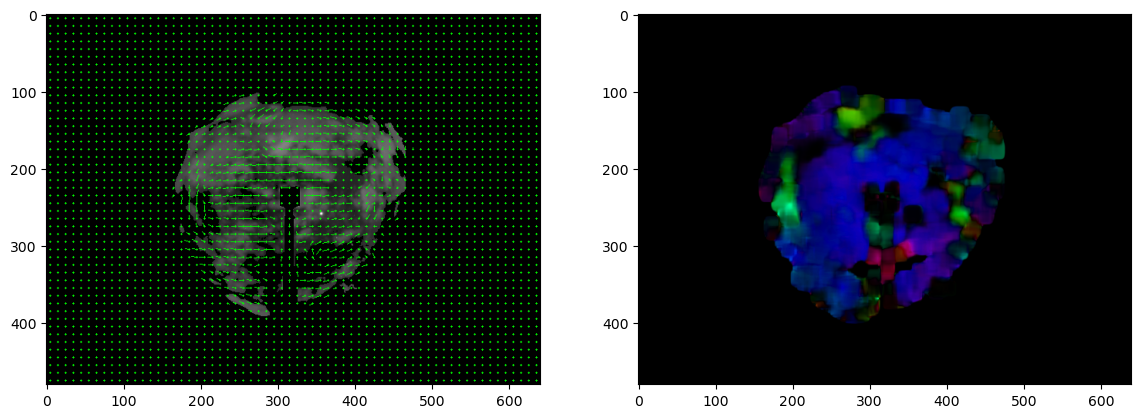

In [20]:

import time

prevgray = cv2.cvtColor(prev_img, cv2.COLOR_BGR2GRAY)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

flow = cv2.calcOpticalFlowFarneback(prevgray, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
# prevgray = gray


def draw_flow(img, flow, step=10):

    h, w = img.shape[:2]
    y, x = np.mgrid[step/2:h:step, step/2:w:step].reshape(2,-1).astype(int)
    fx, fy = flow[y,x].T

    lines = np.vstack([x, y, x-fx, y-fy]).T.reshape(-1, 2, 2)
    lines = np.int32(lines + 0.5)

    img_bgr = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    cv2.polylines(img_bgr, lines, 0, (0, 255, 0))

    for (x1, y1), (_x2, _y2) in lines:
        cv2.circle(img_bgr, (x1, y1), 1, (0, 255, 0), -1)

    return img_bgr

draw_flow_img = draw_flow(gray, flow)
draw_flow_prev = draw_flow(prevgray, flow)

def draw_hsv(flow):

    hsv = np.zeros_like(img)
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsv[..., 0] = ang*180/np.pi/2
    hsv[..., 1] = 255
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    
    return bgr, mag, ang, hsv

draw_hsv_img, mag, ang, hsv = draw_hsv(flow)


plt.figure(figsize=(14,8))
plt.subplot(1,2,1)
plt.imshow(draw_flow_img)


plt.subplot(1,2,2)
plt.imshow(draw_hsv_img)


As can be seen, dense optical flow is very useful in determining the velocity of the clouds in the images, the image to the left shows all the velocity vectors calculated from those two frames; the image to the right showcases the difference in direction of flow in the different regions of the image. Lucas-Kanade method by regular border tracking means would have struggled to detect different velocity directions in this example. The downside to only using a dense optical flow algorithm lies in the fact that there is not a any tracking implemented directly so it has to be made on top of it. OpenCVs Lucas-Kanade's implementation would be perfect for the task if done simultaniously with the dense optical flow field to determine the best points to track. 

With this in mind, it is necessary to determine some points to track from the Farnebacks algorithm. The following code segements the image of the right by color (that means velocity in the same direction) and is multiplied with the original input image to determine the average velocity of different areas (clouds). Then the points to track are defined as the centroid of these areas. 

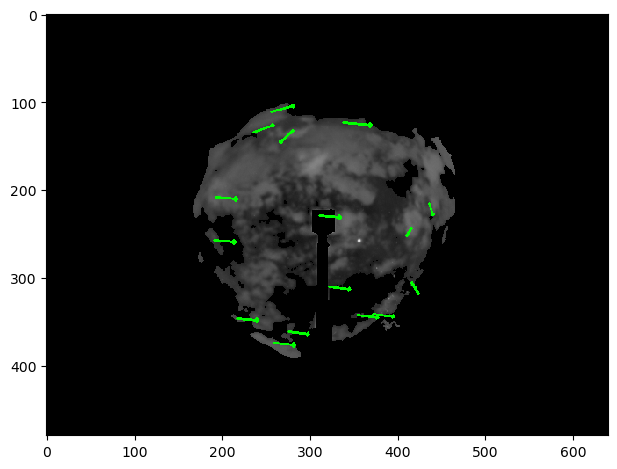

In [21]:
from skimage import measure, color, io
from skimage.filters import threshold_otsu

#### Label for velocity 
# Read the image
image = draw_hsv_img
# Convert the image to the Lab color space
image_lab = color.rgb2lab(image)
# Separate the L, a, and b channels
L, a, b = image_lab[:, :, 0], image_lab[:, :, 1], image_lab[:, :, 2]
# Use Otsu's thresholding on the L channel to create a binary mask
thresh = threshold_otsu(L)
binary_mask = L > thresh
small_binary = remove_small(binary_mask)
# Label connected components in the binary mask
labeled_image, num_labels = label(small_binary, connectivity=2, return_num=True)
# Display the original image, binary mask, and labeled image
# io.imshow(image)
# io.show()

# io.imshow(labeled_image)
# io.show()


for num in range(1,num_labels+1):
    num_mask = labeled_image == num
    x_flow = flow[:,:,0] * num_mask
    y_flow = flow[:,:,1] * num_mask
    non_zero_elements_x = x_flow[x_flow != 0]
    non_zero_elements_y = y_flow[y_flow != 0]
    average_non_zero_x = np.average(non_zero_elements_x)
    average_non_zero_y = np.average(non_zero_elements_y)
    
    over_img = img[:,:,0] * num_mask
    mask_over_img = over_img !=0
    small_ovr = remove_small(mask_over_img, c=0.0001)
    label_over_small, small_id = label(small_ovr, return_num=True)

    for labl in range(1,small_id+1): 
        centroide = measure.centroid(label_over_small == labl)   
        line_img = cv2.arrowedLine(img,
                            (int(centroide[1]), int(centroide[0])),
                            (int(centroide[1] + average_non_zero_x * 5), int(centroide[0] + average_non_zero_y * 5)),
                            (0,255,0), 2)
io.imshow(line_img)

The points resulting from this process make possible the storage of the velocity of them for later usage, as well as being the input in a Lukas-Kanade implementation for determining the trajectories (perhaps using them together could yield some useful results too).

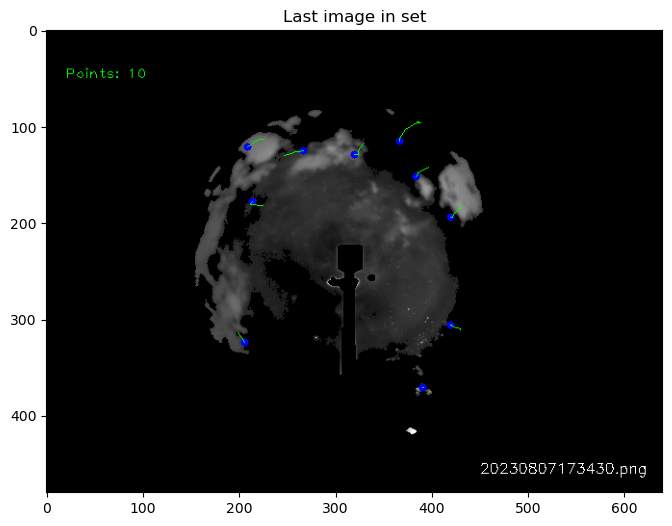

In [22]:
import json
# Parameter definitos for LK optical flow and border detection
lk_params = dict(winSize=(15, 15),
                  maxLevel=2,
                  criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

feature_params = dict(maxCorners=100,
                      qualityLevel=0.3,
                      minDistance=10,
                      blockSize=7)

trajectory_len = 40
detect_interval = 5
trajectories = []
frame_idx = 0

# Specify the path to the folder containing images
# image_folder = '20230807'
# # # presegemented image folder (for speed)
# image_folder = '20230807_seg_yen'
image_folder = '20230807_seg_avg'


# Get the list of image files in the folder
image_files = sorted([f for f in os.listdir(image_folder) if f.endswith(('.jpg', '.png', '.jpeg', '.jp2'))])
# Read and preprocess the first image
first_im = os.path.join(image_folder, image_files[0])
# mask_1, prev_gray = segmentation(first_im)
# # If the images are already segmented use the command below
prev_gray = cv2.imread(first_im)

prev_gray = cv2.cvtColor(prev_gray, cv2.COLOR_BGR2GRAY)

image_data = {}

# for image_file in image_files[900:965]:
for image_file in image_files[900:910]:
    # Construct the full path to the image
    image_path = os.path.join(image_folder, image_file)

    # Read and preprocess the image
    # mask_1, frame = segmentation(image_path)
    # # If the images are already segmented use the command below
    frame = cv2.imread(image_path)
    
    
    # Image gets transformed to single channel gray
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    lk_img = frame.copy()

    # Calculate optical flow for a sparse feature set using the iterative Lucas-Kanade Method
    if len(trajectories) > 0:
        img0, img1 = prev_gray, gray
        p0 = np.float32([trajectory[-1] for trajectory in trajectories]).reshape(-1, 1, 2)
        p1, _st, _err = cv2.calcOpticalFlowPyrLK(img0, img1, p0, None, **lk_params)
        p0r, _st, _err = cv2.calcOpticalFlowPyrLK(img1, img0, p1, None, **lk_params)
        d = abs(p0-p0r).reshape(-1, 2).max(-1)
        good = d < 10
        # Store data for the current image
        # Convert NumPy arrays to Python lists
        trajectories_list = [[[float(coord) for coord in point] for point in trajectory] for trajectory in trajectories]

        # Extract flow information for all_centroids
        flow_info = []
        for centroid in all_centroids:
            x, y = round(centroid[0]), round(centroid[1])
            flow_values = flow[x, y, :].tolist()
            flow_info.append({
                'centroid': [centroid[0],centroid[1]],
                # 'centroid': [x, y],
                'flow': flow_values
            })
            
        # Store data for the current image
        image_data[image_file] = {
            'flag': flag,
            'trajectories': trajectories_list,
            'flow_info': flow_info
        }
        new_trajectories = []

        # Get all the trajectories
        for trajectory, (x, y), good_flag in zip(trajectories, p1.reshape(-1, 2), good):
            if not good_flag:
                continue
            trajectory.append((x, y))
            if len(trajectory) > trajectory_len:
                del trajectory[0]
            new_trajectories.append(trajectory)
            # Newest detected point
            cv2.circle(lk_img, (int(x), int(y)), 4, (0, 0, 255), -1)

        trajectories = new_trajectories

        # Draw all the trajectories
        cv2.polylines(lk_img, [np.int32(trajectory) for trajectory in trajectories], False, (0, 255, 0))
        cv2.putText(lk_img, image_file, (450, 460),
                     cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
        cv2.putText(lk_img, 'Points: %d' % len(trajectories), (20, 50), cv2.FONT_HERSHEY_PLAIN, 1, (0,255,0), 1)

    # Update interval - When to update and detect new features
    if frame_idx % detect_interval == 0:
        mask = np.zeros_like(gray)
        mask[:] = 255

        # Lastest point in latest trajectory
        for x, y in [np.int32(trajectory[-1]) for trajectory in trajectories]:
            cv2.circle(mask, (x, y), 5, 0, -1)
            # vel_x, vel_y = flow[x, y, :]
        
        
        
        flow = cv2.calcOpticalFlowFarneback(prev_gray, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)

        def draw_hsv(flow):

            hsv = np.zeros_like(frame)
            mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
            hsv[..., 0] = ang*180/np.pi/2
            hsv[..., 1] = 255
            hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
            bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
            
            return bgr, mag, ang, hsv

        draw_hsv_img, mag, ang, hsv = draw_hsv(flow)

        #### Label for velocity 
        # Read the image
        image = draw_hsv_img
        # Convert the image to the Lab color space
        image_lab = color.rgb2lab(image)
        # Separate the L, a, and b channels
        L, a, b = image_lab[:, :, 0], image_lab[:, :, 1], image_lab[:, :, 2]
        # Use Otsu's thresholding on the L channel to create a binary mask
        thresh = threshold_otsu(L)
        binary_mask = L > thresh
        small_binary = remove_small(binary_mask)
        # Label connected components in the binary mask
        labeled_image, num_labels = label(small_binary, connectivity=2, return_num=True)

        all_centroids = []

        for num in range(1,num_labels+1):
            num_mask = labeled_image == num
            x_flow = flow[:,:,0] * num_mask
            y_flow = flow[:,:,1] * num_mask
            non_zero_elements_x = x_flow[x_flow != 0]
            non_zero_elements_y = y_flow[y_flow != 0]
            average_non_zero_x = np.average(non_zero_elements_x)
            average_non_zero_y = np.average(non_zero_elements_y)
            
            over_img = frame[:,:,0] * num_mask
            mask_over_img = over_img !=0
            small_ovr = remove_small(mask_over_img, c=0.0001)
            label_over_small, small_id = label(small_ovr, return_num=True)

            for labl in range(1,small_id+1): 
                centroide = measure.centroid(label_over_small == labl)
                all_centroids.append(centroide)
                line_img = cv2.arrowedLine(frame,
                                    (int(centroide[1]), int(centroide[0])),
                                    (int(centroide[1] + average_non_zero_x * 5), int(centroide[0] + average_non_zero_y * 5)),
                                    (0,255,0), 2)

        centroids_array = np.float32(all_centroids).reshape(-1, 1, 2)
        # Use the points from centroids_array
        p = centroids_array
        
        # If points are available, add them to the trajectories
        if p is not None:
            for y, x in p.reshape(-1, 2):
                trajectories.append([(x, y)])

    frame_idx += 1
    prev_gray = gray

    # Show Results
    cv2.imshow('Optical Flow', lk_img)
    # cv2.imshow('Mask', mask)

    if cv2.waitKey(10) & 0xFF == ord('q'):
        break


cv2.destroyAllWindows()

plt.figure(figsize=(10,6))
plt.title('Last image in set')
plt.imshow(lk_img)

# Save the data as a JSON file
with open('image_data.json', 'w', encoding='utf-8') as f:
    json.dump(image_data, f, ensure_ascii=False, indent=4)


In [23]:
image_data

{'20230807173030.png': {'flag': 'sun_covered',
  'trajectories': [[[385.7592468261719, 95.53704071044922]],
   [[389.5869445800781, 153.1086883544922]],
   [[403.58416748046875, 255.4280548095703]],
   [[430.8235168457031, 311.0882263183594]],
   [[304.0806579589844, 348.6129150390625]],
   [[227.48101806640625, 347.6329040527344]],
   [[391.93389892578125, 371.362060546875]],
   [[353.5113525390625, 241.6704559326172]]],
  'flow_info': [{'centroid': [95.53703703703704, 385.75925925925924],
    'flow': [8.439516067504883, 7.411264896392822]},
   {'centroid': [153.1086956521739, 389.5869565217391],
    'flow': [-7.443257808685303, -9.525834083557129]},
   {'centroid': [255.42805118110238, 403.5841535433071],
    'flow': [-5.823337554931641, -10.599265098571777]},
   {'centroid': [311.0882352941176, 430.8235294117647],
    'flow': [-3.300299644470215, -12.967207908630371]},
   {'centroid': [348.61290322580646, 304.0806451612903],
    'flow': [0.1387425661087036, -21.61541748046875]},
   

Notice how in the above image, the trajectories are able to capture the velocity of the top left area; this was not possible before using the `GoodFeaturesToTrack()` function.

### 5. Resulting data

Average value within the disk: 60.97089471793029


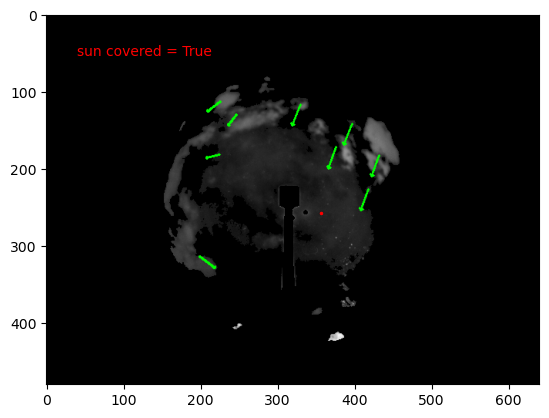

In [24]:
import pvlib
import pandas as pd

# filepath = '20230808_normal/20230808190630.png'


def solar_pos(filepath):
    
    tz = 'America/Bogota'
    lat, lon = 9.789103, -73.722451 # 9.789103, -73.722451 Esta es las coordenas
    altitude = 50

    #Ubicación Geográfica
    location = pvlib.location.Location(lat, lon, tz, altitude)
    times = pd.date_range('2023-01-01 00:00:00', '2024-12-31', closed='left',
                          freq='H', tz=tz)
    solpos = pvlib.solarposition.get_solarposition(times, lat, lon)
    # remove nighttime
    solpos = solpos.loc[solpos['apparent_elevation'] > 0, :]
    # draw hour labels
    for hour in np.unique(solpos.index.hour):
        # choose label position by the smallest radius for each hour
        subset = solpos.loc[solpos.index.hour == hour, :]
        r = subset.apparent_zenith
        pos = solpos.loc[r.idxmin(), :]
        # ax.text(np.radians(pos['azimuth']), pos['apparent_zenith'], str(hour))
    YY = filepath[-18:-14]
    MM = filepath[-14:-12]
    DD = filepath[-12:-10]
    day = YY+'-'+MM+'-'+DD
    # draw individual days
    for date in pd.to_datetime([day]):
        times = pd.date_range(date, date+pd.Timedelta('24h'), freq='30s', tz=tz)
        solpos = pvlib.solarposition.get_solarposition(times, lat, lon)
        solpos = solpos.loc[solpos['apparent_elevation'] > 0, :]
        label = date.strftime('%Y-%m-%d')
        azimuth_radians = np.radians(solpos.azimuth)

    # Convert polar coordinates to Cartesian coordinates
    x_direct = solpos.apparent_zenith * np.sin(azimuth_radians)
    y_direct = solpos.apparent_zenith * np.cos(azimuth_radians)

    # Adjust Cartesian coordinates for a (480,640) image
    x = -(x_direct)*3.18+312
    k=0.0073; x0=304.4; a=85; L=477
    x_mapped = L / (1 + np.exp(-k * (x - x0))) + a
    y_mapped =  y_direct*2 + 238

    # Rotate about center 3.5 degrees
    x_c = 314; y_c = 235; j_rot = np.deg2rad(3.5)
    x_rot = (x_mapped - x_c)* np.cos(j_rot)- (y_mapped-y_c)*np.sin(j_rot) + x_c
    y_rot = (x_mapped - x_c)* np.sin(j_rot)+ (y_mapped-y_c)*np.cos(j_rot) + y_c

    # Reflect about x axis
    x_final = x_rot - 13
    y_final = -y_rot + 478


    return x_final, y_final, day


# gets the time from the filepath following the convention '~/YYYYMMDDhhmmss.png'
def get_time (filepath):
    st = filepath[-10:-4]
    hh = str(int(st[0:2])-5)
    if len(hh) == 1:
        hh = '0'+hh
    mm = st[2:4]
    ss = st[4:6]
    timer = hh + ':'+ mm + ':' + ss
    
    
    
    return timer

def get_solar_coords (x_mapped, y_mapped, day, timer):
    x = x_mapped[day + ' ' + timer + '-05:00']
    y = y_mapped[day + ' ' + timer + '-05:00']
    
    return x, y
    
    
x_mapped, y_mapped, day = solar_pos(filepath)
timer = get_time (filepath)
solar_x, solar_y =  get_solar_coords (x_mapped, y_mapped, day, timer)
solar_y = 480 - solar_y

from skimage.draw import disk
def average_disk_value(image, center, inner_radius, outer_radius):
    # Create an array of coordinates for the disk
    rr, cc = disk(center, outer_radius)
    
    # Remove coordinates outside the inner radius
    inner_rr, inner_cc = disk(center, inner_radius)
    mask = np.in1d(rr, inner_rr) & np.in1d(cc, inner_cc)
    rr, cc = rr[mask], cc[mask]
    
    # Extract pixel values within the disk
    values = image[rr, cc]
    
    # Calculate and return the average value
    average_value = np.mean(values)
    return average_value

# Example usage
point = (solar_y, solar_x)  # Replace this with the coordinates of your point

inner_radius = 29
outer_radius = 30

result = average_disk_value(img, point, inner_radius, outer_radius)
print("Average value within the disk:", result)


covered = mask[round(solar_x),round(solar_y)] > 0


img = line_img
# Create a figure and axis for the imag
fig, ax = plt.subplots()
ax.imshow(img)
ax.plot(solar_x, solar_y, 'r.', markersize=3, label=label)
ax.text(0.2, 0.9, 'sun covered = '+str(covered), color = 'r',horizontalalignment='center',
     verticalalignment='center', transform=ax.transAxes)
# ax.plot(x_mapped, y_mapped,'r' , label=label)

# plt.savefig('foo.png')
# plt.close() 
plt.show()